# Orbit and stream simulation
## Base potential model: McMillan17

# 1. Orbit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from astropy import units
from astropy.io import ascii
import corner
from plot_functions import *

from galpy.orbit import Orbit
from galpy.util.conversion import get_physical
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf
from galpy.potential.mwpotentials import McMillan17

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# params imported from plot_functions
params['xtick.labelsize'] = 12
params['ytick.labelsize'] = 12
params['axes.labelsize'] = 12
params['axes.titlesize'] = 14
plt.rcParams.update(params)

### Data from other sources

In [3]:
styx_trace = ascii.read('styx.trace')

# from Dr. Erkal
data_wlmc = ascii.read('dwarf_stream_bootes_3_wLMC.txt')
data_wolmc = ascii.read('dwarf_stream_bootes_3_woLMC.txt')

## Functions

Note a few physical values from galpy's default configuration:
- Solar radius R = 8 kpc
- Circular velocity V = 220 km/s
- Solar motion [Schoenrich 2010](http://adsabs.harvard.edu/abs/2010MNRAS.403.1829S)

**Now with McMillan17, the R and V are different:**

In [4]:
get_physical(McMillan17)

{'ro': 8.21, 'vo': 233.1}

In [5]:
SOLAR_MOTION = [-11.1, 12.24, 7.25]

In [6]:
def get_total_potential(base_potential, forward=False):
    """Return a potential that combines <base_potential> with
    the LMC's potential, plus a non-inertial frame force (the MW's 
    reflex motion in response to the LMC's infall).
    
    The potential created is only valid for 5 Gyr in forward/backward 
    modelling. If <forward> is True, the potential is created for
    forward integration.
    
    Note: 
    - The <rscale> variable defined below is the "scale radius",
      which is the variable (a) found in Eq. 3 from Hernquist 1990.
    - The <rhm> variable is the "half-mass radius", its relation
      with the scale radius is given by: rhm = a * (1 + sqrt(2))
    """
    mass_lmc = 1.38e11               # M_sun
    rscale = 16.09                   # kpc
    rhm = rscale * (1 + np.sqrt(2))  # kpc
    
    # Define LMC orbit object and dynamical friction force
    # Then, integrate the LMC orbit and turn it into a moving potential model.
    orbit_LMC = Orbit.from_name('LMC', solarmotion=SOLAR_MOTION, **get_physical(base_potential))
    
    if base_potential == McMillan17:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc,
                                                  dens=base_potential[1],
                                                  **get_physical(base_potential))
    else:
        cdf = ChandrasekharDynamicalFrictionForce(GMs=mass_lmc*units.Msun, rhm=rhm*units.kpc,
                                                  **get_physical(base_potential))

    ts = np.linspace(0, 5, 1001)*units.Gyr  # fixed timescale
    if forward:
        orbit_LMC.integrate(ts, base_potential + cdf)
    else:
        orbit_LMC.integrate(-ts, base_potential + cdf)
        
    lmcpot = HernquistPotential(amp=2*mass_lmc*units.Msun, a=rscale*units.kpc, **get_physical(base_potential))
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot, **get_physical(base_potential))

    # Create the MW barycentric acceleration
    # Acceleration at origin
    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    # Use interpolation function to speed things up
    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return base_potential + nip + moving_lmcpot

In [7]:
def ax_plot_realizations(ax, component_for_x, component_for_y):
    """
    **Required for generate_orbit_model**
    
    Take every 10th element in <component_for_x> and <component_for_y>, which are
    attributes of an Orbit instance that contains many orbits, and plot them onto <ax>.
    
    This is for convenient plotting of the many realizations of orbits made to account
    for the 6D parameters uncertainties.
    """
    for (x, y) in zip(component_for_x[::10], component_for_y[::10]):
        ax.plot(x, y, c='deepskyblue', alpha=0.1, zorder=1)

    
def generate_orbit_model(params_6D, errors_6D, max_time, base_potential,
                         potential_forward, potential_backward,
                         solar_motion=SOLAR_MOTION, num_of_realizations=1000, 
                         skip_forward=False, plots_only=False, save_plots=False, 
                         title_text='', save_text=''):
    """The complete function for integrating and displaying the orbit.
    
    Note: Separate potential variables are required for forward and 
    backward modelling, because the LMC is a moving potential, so 
    backward potential requires the rewind orbit of LMC.
    
    Parameters
    ----------
    params_6D:
        The 6D phase-space parameters of the dwarf galaxy. 
        In this order, [ra, dec, distance, pmra, pmdec, velocity].
    errors_6D:
        The uncertainties for the 6D parameters. 
        Enter 0 for the parameters that do not have uncertainties.
    max_time:
        The time (in Gyr) for the integration to run until. 
        This is used to create a numpy array for the timescale.
    base_potential:
        A galpy built-in potential model.
        This should be the one that was used to create 
        <potential_forward> and <potential_backward>.
    potential_forward:
        A custom potential model including the LMC and MW reflex motion.
        For forward integration only.
    potential_backward:
        Similar as above, but for backward integration.
    solar_motion:
        The same solar motion parameter as in galpy.
        This is an option to change the total solar velocity V_phi, 
        which is an empirical value important for coordinate conversions.
    num_of_realizations:
        The number of orbits to generate given the uncertainties on
        the 6D parameters.
    skip_forward:
        If true, skip the forward integration 
        (the returned forward parts will not work).
    plots_only:
        If true, return no values and only generate a plot.
    save_plots:
        If true, save the plot with the file name as <save_text>.
    title_text:
        The title of the plot.
    save_text:
        The file name of the saved plot.
    
    Return
    ------
    If <plots_only> is False (default):
        Return the galpy Orbit objects that represent the model result.
        This includes the forward orbit, backward orbit, their 
        different realizations, and the timescale array.
    If <plots_only> is True:
        Return nothing.
        Only show the plots of the orbit integration.
    """
    # Prepare the parameters for the realizations
    params_6D_many = np.random.normal(loc=params_6D, scale=errors_6D, 
                                      size=(num_of_realizations, 6))
    # Make timescale
    ts = np.linspace(0, max_time, 1001) * units.Gyr

    # Create orbits
    orbit_forward = Orbit(params_6D, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    orbit_backward = Orbit(params_6D, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    orbit_forward_many = Orbit(params_6D_many, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    orbit_backward_many = Orbit(params_6D_many, solarmotion=solar_motion, radec=True, **get_physical(base_potential))
    
    # Integrate
    orbit_forward.integrate(ts, potential_forward)
    orbit_backward.integrate(-ts, potential_backward)
    orbit_forward_many.integrate(ts, potential_forward)
    orbit_backward_many.integrate(-ts, potential_backward)
    
    # Plot in this order: XY-plane, XZ-plane, YZ-plane, and R vs. t
    fig, axs = plt.subplots(1, 4, figsize=(12.4, 3))

    for ax, plane in zip(axs, ['XY', 'XZ', 'YZ', 'RT']):
        # Determine what we are plotting
        if plane == 'XY':
            xf, yf = orbit_forward.x(ts), orbit_forward.y(ts)                        # "forward"
            xb, yb = orbit_backward.x(-ts), orbit_backward.y(-ts)                    # "backward" 
            xf_err, yf_err = orbit_forward_many.x(ts), orbit_forward_many.y(ts)      # their "errors"
            xb_err, yb_err = orbit_backward_many.x(-ts), orbit_backward_many.y(-ts)
        elif plane == 'XZ':
            xf, yf = orbit_forward.x(ts), orbit_forward.z(ts)
            xb, yb = orbit_backward.x(-ts), orbit_backward.z(-ts)
            xf_err, yf_err = orbit_forward_many.x(ts), orbit_forward_many.z(ts)
            xb_err, yb_err = orbit_backward_many.x(-ts), orbit_backward_many.z(-ts)
        elif plane == 'YZ':
            xf, yf = orbit_forward.y(ts), orbit_forward.z(ts)
            xb, yb = orbit_backward.y(-ts), orbit_backward.z(-ts)
            xf_err, yf_err = orbit_forward_many.y(ts), orbit_forward_many.z(ts)
            xb_err, yb_err = orbit_backward_many.y(-ts), orbit_backward_many.z(-ts)
        else:
            # No need the forward part for R vs. t
            skip_forward = True
            xb, yb = orbit_backward.time(-ts), orbit_backward.r(-ts)
            xb_err = np.tile(orbit_backward_many.time(-ts), (num_of_realizations, 1))
            yb_err = orbit_backward_many.r(-ts)

        # forward
        if not skip_forward:
            ax.plot(xf, yf, c='k', ls='-', zorder=2)
            ax_plot_realizations(ax, xf_err, yf_err)
        # backward
        ax.plot(xb, yb, c='k', ls='--', zorder=2)
        ax_plot_realizations(ax, xb_err, yb_err)

        ax.plot(xb[0], yb[0], 'ok', zorder=2)
        if plane != 'RT':
            ax.set_xlabel(plane[0] + ' [kpc]')
            ax.set_ylabel(plane[1] + ' [kpc]')
            ax.set_xlim(-125, 125)
            ax.set_ylim(-125, 125)
        else:
            ax.set_xlabel('t [Gyr]')
            ax.set_ylabel('R [kpc]')
            ax.set_ylim(0, 160)

        ax.set_aspect('auto')

    plt.tight_layout()
    plt.suptitle(title_text, y=1.05)
    if save_plots:
        fig.savefig(f'{save_text}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    if not plots_only:
        return orbit_forward, orbit_backward, orbit_forward_many, orbit_backward_many, ts
    else:
        return

### Input setup

In [8]:
# 6D parameters
RA_BOO3 = 209.3     # deg  (from Grillmair 2009)
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc  (from Carlin 2018)
PMRA_BOO3 = -1.16   # mas yr^-1  (from Part 1 of this work)
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 191.31   # km s^-1

# Uncertainties (no value for positions)
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 0.74   

boo3_6D = [RA_BOO3, DEC_BOO3, DIST_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3]
boo3_6D_err = [0, 0, U_DIST_BOO3, U_PMRA_BOO3, U_PMDEC_BOO3, U_VEL_BOO3]

## McMillan17

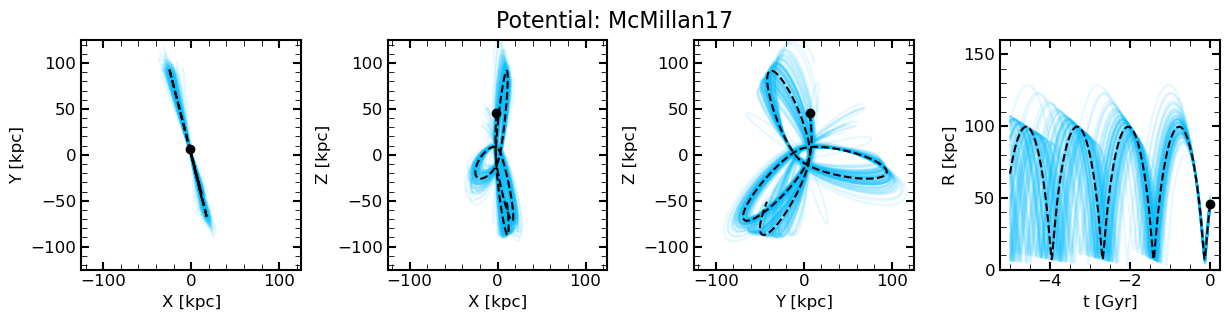

In [9]:
result = generate_orbit_model(params_6D=boo3_6D, errors_6D=boo3_6D_err, max_time=5, 
                              base_potential=McMillan17, 
                              potential_forward=McMillan17,
                              potential_backward=McMillan17,
                              skip_forward=True,
                              save_plots=True,
                              title_text='Potential: McMillan17', 
                              save_text='orbit_McMillan17')

orbit_forward, orbit_backward, orbit_forward_many, orbit_backward_many, ts = result

## McMillan17 + LMC + reflex motion (barycentric acceleration)

In [10]:
total_potential_backward = get_total_potential(McMillan17)
total_potential_forward = get_total_potential(McMillan17, forward=True)

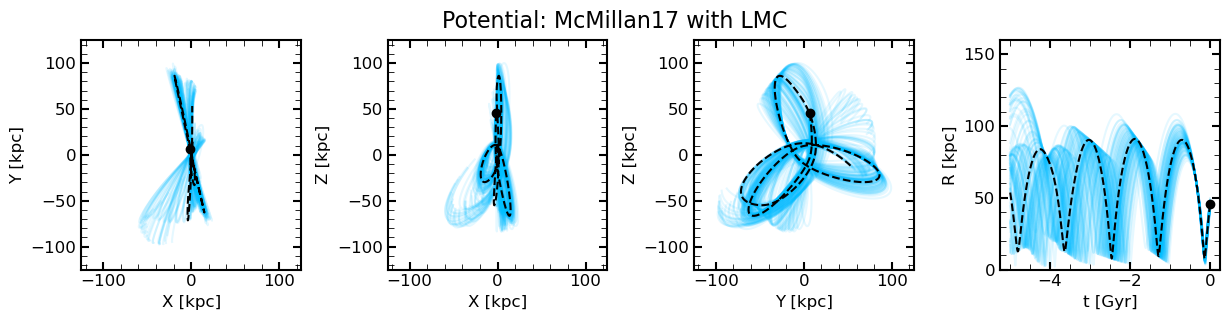

In [11]:
result2 = generate_orbit_model(params_6D=boo3_6D, errors_6D=boo3_6D_err, max_time=5, 
                              base_potential=McMillan17, 
                              potential_forward=total_potential_forward,
                              potential_backward=total_potential_backward,
                              skip_forward=True,
                              save_plots=True,
                              title_text='Potential: McMillan17 with LMC', 
                              save_text='orbit_McMillan17_LMC')

orbit_forward2, orbit_backward2, orbit_forward_many2, orbit_backward_many2, ts2 = result2

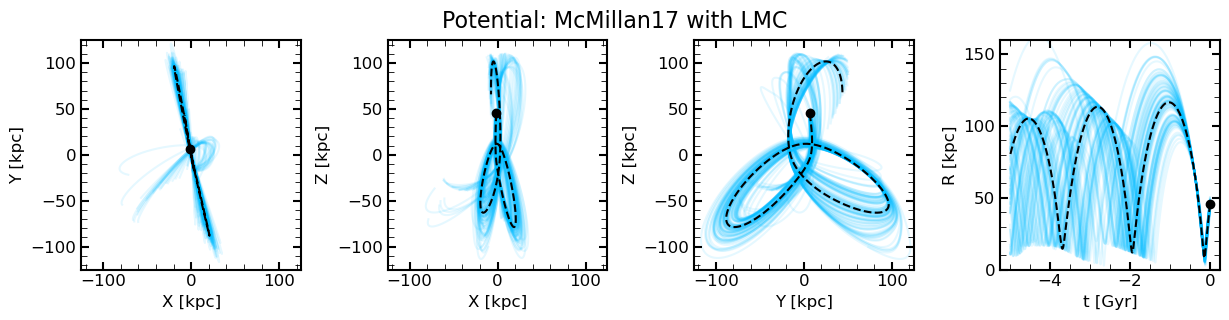

In [11]:
result2 = generate_orbit_model(boo3_6D, boo3_6D_unc, 5, 
                               total_potential_forward, total_potential_backward,
                               skip_forward=True,
                               save_plots=True, 
                               
result2 = generate_orbit_model(params_6D=boo3_6D, errors_6D=boo3_6D_err, max_time=5, 
                              base_potential=McMillan17, 
                              potential_forward=total_potential_forward,
                              potential_backward=total_potential_backward,
                              skip_forward=True,
                              save_plots=True,
                              title_text='Potential: McMillan17 with LMC', 
                              save_text='orbit_McMillan17_LMC')

orbit_forward2, orbit_backward2, orbit_forward_many2, orbit_backward_many2, ts2 = result2

## Orbital properties

For getting the most recent pericenter and apocenter, we can't use the built-in rperi() and rap() because they take the global extremum values. We will use a scipy trick to get the indices of all pericenters and apocenters, and take the first index.

The commented lines will show the difference between using the scipy trick and using rperi() and rap(). The latter result *may not be* the most recent pericenter and apocenter passages.

In [12]:
def generate_peri_apo_distributions(orbits, ts, fig_title='', save_title=''):
    all_peri = []
    all_apo = []
    for orbit in orbits:
        peri_index = argrelextrema(orbit.r(-ts), np.less)[0][0]
        all_peri.append(orbit.r(-ts)[peri_index])
        apo_index = argrelextrema(orbit.r(-ts), np.greater)[0][0]
        all_apo.append(orbit.r(-ts)[apo_index])

    figure = corner.corner(np.vstack((all_peri, all_apo, orbits.e())).T,
                       labels=['$r_\mathrm{peri}$', '$r_\mathrm{apo}$', '$e$'],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True,
                       #plot_datapoints=False,
                       title_kwargs={"fontsize": 13},
                       label_kwargs = dict(fontsize=15),
                       #range=[[np.array(all_peri).min(), np.array(all_peri).max()], [np.array(all_apo).min(), np.array(all_apo).max()], [0.87, orbits.e().max()]],
                       ls='--', c='gray')
    figure.set_size_inches(6, 6)
    
    axes = figure.get_axes()
    axes[0].text(3, 0.5, fig_title, fontsize=14, ha='right', va='top', transform=axes[0].transAxes)
    figure.savefig(save_title, dpi=300, bbox_inches='tight')
    plt.show()

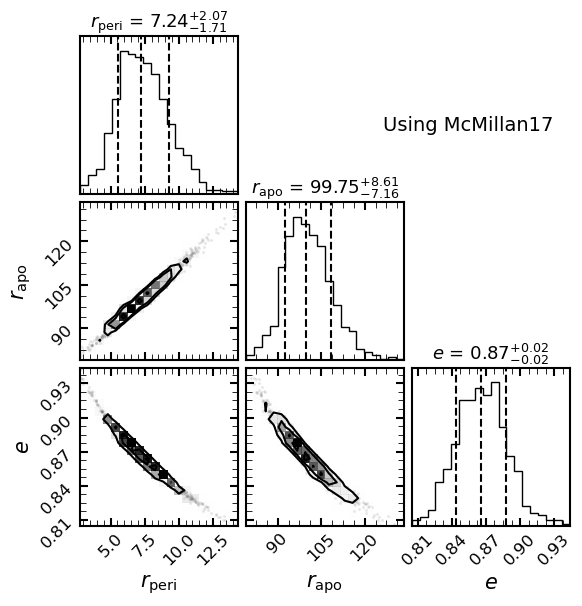

In [13]:
generate_peri_apo_distributions(orbit_backward_many, ts,
                                fig_title='Using McMillan17', 
                                save_title='orbit_params_nolmc_mcmillan.png')

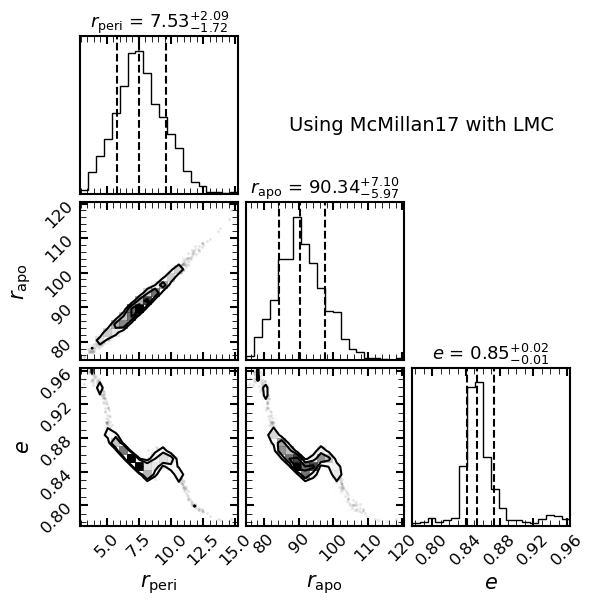

In [14]:
generate_peri_apo_distributions(orbit_backward_many2, ts2,
                                fig_title='Using McMillan17 with LMC', 
                                save_title='orbit_params_wlmc_mcmillan.png')